# Gene Embedding Analysis with Multiple Coloring Schemes

This notebook creates gene embedding plots colored by:
1. Gene type (cell type association)
2. Number of mutually exclusive gene relationships
3. Number of cell types each gene was a candidate for

The analysis provides insights into gene specificity and exclusivity patterns.


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scanpy as sc
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project paths
project_root = Path('.').absolute()
sys.path.append(str(project_root))
sys.path.append(str(project_root / 'visualization'))
sys.path.append(str(project_root / 'utils'))

# Import custom modules
from visualization.embedding_visualization import (
    visualize_gene_embeddings_from_model,
    EmbeddingVisualizationConfig,
    EmbeddingVisualizer,
    EmbeddingExtractor
)
from utils.utils import setup_model_and_data, load_metadata, VisualizationConfig, find_mutually_exclusive_genes
from utils.simple_gene_celltype_mapping import (
    extract_gene_celltype_dict, 
    compute_mutually_exclusive_gene_counts
)

from visualization.utils import load_cell_type_color_palette
# Import from model training for mutually exclusive genes
sys.path.append(str(project_root.parent / 'src'))
from segger.data.parquet._utils import find_markers

print("✅ All imports successful!")


✅ All imports successful!


## Configuration


In [2]:
# Configuration
DATASET = 'colon'  # Change to 'CRC', 'pancreas', or 'breast' as needed
MODEL_TYPE = 'seq'  # 'seq' or 'no_seq'
ALIGN_LOSS = True  # Whether using align loss model
USE_SCRNASEQ = True  # Whether to use scRNA-seq data

# Data directories
DATA_DIR = Path('/dkfz/cluster/gpu/data/OE0606/fengyun')
XENIUM_DATA_DIR = DATA_DIR / 'xenium_data' / f'xenium_{DATASET}'

if USE_SCRNASEQ:
    if DATASET in ['colon', 'CRC']:
        SCRNASEQ_FILE = DATA_DIR / 'xenium_data' / 'xenium_colon' / 'scRNAseq.h5ad'
        CELLTYPE_COLUMN = "Level1"
    elif DATASET == 'breast':
        SCRNASEQ_FILE = DATA_DIR / 'xenium_data' / 'xenium_breast' / 'scRNAseq.h5ad'
        CELLTYPE_COLUMN = "celltype_major"
    elif DATASET == 'pancreas':
        raise ValueError("scRNA-seq not available for pancreas dataset")

# Output directory
save_dir = Path('./embedding_visualization_results') / DATASET / MODEL_TYPE
if ALIGN_LOSS:
    save_dir = save_dir / 'align_loss'
else:
    save_dir = save_dir / 'original_loss'
save_dir.mkdir(parents=True, exist_ok=True)

print(f"Dataset: {DATASET}")
print(f"Model type: {MODEL_TYPE}")
print(f"Align loss: {ALIGN_LOSS}")
print(f"Use scRNA-seq: {USE_SCRNASEQ}")
print(f"Save directory: {save_dir}")


Dataset: colon
Model type: seq
Align loss: True
Use scRNA-seq: True
Save directory: embedding_visualization_results/colon/seq/align_loss


## Load Model and Data


In [3]:
# Create configuration
config = VisualizationConfig(
    dataset=DATASET,
    model_type=MODEL_TYPE,
    align_loss=ALIGN_LOSS,
    load_scrna_gene_types=USE_SCRNASEQ,
    #max_points_per_type=1000,
    embedding_method='umap'
)

# Load model and data
print("Loading model and data...")
model, dm = setup_model_and_data(config)
print("✅ Model and data loaded successfully!")

# Load transcripts metadata
transcripts_df = pd.read_parquet(XENIUM_DATA_DIR / 'transcripts.parquet')
print(f"Loaded {len(transcripts_df)} transcripts")


Loading model and data...
Auto-detected latest model version: 2
Auto-detected checkpoint: /dkfz/cluster/gpu/data/OE0606/fengyun/segger_model_align/segger_colon_seq/segger_with_embeddings/version_2/checkpoints/epoch=199-step=89400.ckpt
Successfully loaded model from /dkfz/cluster/gpu/data/OE0606/fengyun/segger_model_align/segger_colon_seq/segger_with_embeddings/version_2/checkpoints/epoch=199-step=89400.ckpt
✅ Model and data loaded successfully!
Loaded 79447189 transcripts


## Extract Gene Embeddings


In [ ]:
# Set up spatial region for gene extraction (use larger region for more genes)
spatial_region_gene = None

# Create embedding configuration
embedding_config = EmbeddingVisualizationConfig(
    method='umap',
    n_components=2,
    figsize=(12, 10),
    point_size=3.0,
    alpha=0.7,
    umap_n_neighbors=30,
    umap_min_dist=0.1
)

print("Extracting gene embeddings...")
print(f"Spatial region: {spatial_region_gene}")

# Check if gene embeddings already exist
embeddings_file = save_dir / 'gene_embeddings.pkl'
if embeddings_file.exists():
    print(f"Loading existing gene embeddings from {embeddings_file}")
    visualizer = EmbeddingVisualizer(embedding_config)
    gene_data = visualizer.load_embeddings(embeddings_file)['gene']
else:
    # Extract gene embeddings using the optimized function
    from utils.spatial_batch_utils import get_spatial_combined_dataloader
    
    # Get combined dataloader for gene region
    if spatial_region_gene:
        combined_dataloader = get_spatial_combined_dataloader(
            dm, 
            x_range=[spatial_region_gene[0], spatial_region_gene[1]], 
            y_range=[spatial_region_gene[2], spatial_region_gene[3]], 
            all_regions=False, 
            save_dir=save_dir
        )
    else:
        # Use all regions if no specific region defined
        combined_dataloader = get_spatial_combined_dataloader(
            dm, all_regions=True, save_dir=save_dir
        )
    
    # Extract gene embeddings
    extractor = EmbeddingExtractor()
    gene_data = extractor.extract_gene_embeddings_from_batches(
        model=model.model,
        dataloader=combined_dataloader,
        max_batches=len(combined_dataloader),
        transcripts_df=transcripts_df
    )
    
    # Save gene embeddings
    visualizer = EmbeddingVisualizer(embedding_config)
    visualizer.save_embeddings({'gene': gene_data}, embeddings_file)
    print(f"Gene embeddings saved to {embeddings_file}")

print(f"✅ Gene embeddings loaded: {gene_data['embeddings'].shape[0]} genes")


Extracting gene embeddings...
Spatial region: [2000, 4000, 3000, 5000]
Loading existing gene embeddings from embedding_visualization_results/colon/seq/align_loss/gene_embeddings.pkl
✅ Gene embeddings loaded: 414 genes


## Load and Process scRNA-seq Data


In [5]:
if USE_SCRNASEQ:
    print("Loading and processing scRNA-seq data...")
    
    # Load scRNA-seq data
    scrnaseq = sc.read(SCRNASEQ_FILE)
    sc.pp.subsample(scrnaseq, 0.1)
    scrnaseq.var_names_make_unique()
    
    # Preprocess for analysis
    sc.pp.normalize_total(scrnaseq)
    sc.pp.log1p(scrnaseq)
    
    print(f"scRNA-seq data: {scrnaseq.n_obs} cells, {scrnaseq.n_vars} genes")
    print(f"Cell types: {sorted(scrnaseq.obs[CELLTYPE_COLUMN].unique())}")
    
    # Extract gene-to-cell-type mapping with cell type counts
    print("\nExtracting gene-to-cell-type mapping...")
    gene_types_dict, gene_celltype_counts = extract_gene_celltype_dict(
        scrnaseq,
        celltype_column=CELLTYPE_COLUMN,
        return_celltype_counts=True,
        top_n_genes=200,
        pval_cutoff=0.05,
        logfc_min=0.5
    )
    
    print(f"✅ Gene-to-cell-type mapping: {len(gene_types_dict)} genes")
else:
    gene_types_dict = None
    gene_celltype_counts = None
    print("Skipping scRNA-seq analysis")


Loading and processing scRNA-seq data...
scRNA-seq data: 26050 cells, 18082 genes
Cell types: ['B cells', 'Endothelial', 'Fibroblast', 'Intestinal Epithelial', 'Myeloid', 'Neuronal', 'Smooth Muscle', 'T cells', 'Tumor']

Extracting gene-to-cell-type mapping...
Extracting gene-to-cell-type mapping using method: differential_expression
Found 9 cell types: ['Fibroblast', 'Intestinal Epithelial', 'Tumor', 'B cells', 'T cells', 'Smooth Muscle', 'Myeloid', 'Endothelial', 'Neuronal']
Computing differential expression...
  Found 200 candidate marker genes for Fibroblast (after thresholds)
  Found 200 candidate marker genes for Intestinal Epithelial (after thresholds)
  Found 200 candidate marker genes for Tumor (after thresholds)
  Found 200 candidate marker genes for B cells (after thresholds)
  Found 200 candidate marker genes for T cells (after thresholds)
  Found 200 candidate marker genes for Smooth Muscle (after thresholds)
  Found 200 candidate marker genes for Myeloid (after thresholds

## Compute Mutually Exclusive Gene Relationships


In [6]:
if USE_SCRNASEQ:
    print("Computing mutually exclusive gene pairs...")
    
    # Import the function from model_training.py
    sys.path.append(str(project_root))
    
    # Find common genes between scRNA-seq and spatial data
    common_genes = list(set(scrnaseq.var_names) & set(transcripts_df['feature_name']))
    print(f"Found {len(common_genes)} common genes between scRNA-seq and spatial data")
    
    # Find marker genes
    markers = find_markers(
        scrnaseq[:, common_genes], 
        cell_type_column=CELLTYPE_COLUMN, 
        pos_percentile=90, 
        neg_percentile=20, 
        percentage=20
    )
    
    # Find mutually exclusive gene pairs
    scrnaseq_copy = scrnaseq.copy()
    mutually_exclusive_gene_pairs = find_mutually_exclusive_genes(
        adata=scrnaseq_copy,
        markers=markers,
        cell_type_column=CELLTYPE_COLUMN
    )
    
    print(f"Found {len(mutually_exclusive_gene_pairs)} mutually exclusive gene pairs")
    
    # Compute mutually exclusive gene counts
    gene_exclusive_counts = compute_mutually_exclusive_gene_counts(mutually_exclusive_gene_pairs, common_genes)
    
    print(f"✅ Mutually exclusive gene counts: {len(gene_exclusive_counts)} genes")
else:
    gene_exclusive_counts = None
    print("Skipping mutually exclusive gene analysis")


Computing mutually exclusive gene pairs...
Found 414 common genes between scRNA-seq and spatial data
Found 3654 mutually exclusive gene pairs
Computed mutually exclusive counts for 414 genes
Mutually exclusive distribution:
  320 genes have 0 mutually exclusive relationship(s)
  27 genes have 67 mutually exclusive relationship(s)
  20 genes have 74 mutually exclusive relationship(s)
  13 genes have 81 mutually exclusive relationship(s)
  10 genes have 84 mutually exclusive relationship(s)
  7 genes have 87 mutually exclusive relationship(s)
  6 genes have 88 mutually exclusive relationship(s)
  5 genes have 89 mutually exclusive relationship(s)
  4 genes have 90 mutually exclusive relationship(s)
  2 genes have 92 mutually exclusive relationship(s)
✅ Mutually exclusive gene counts: 414 genes


## Prepare Data for Visualization


In [7]:
# Get gene metadata
gene_metadata = gene_data['metadata'].copy()
gene_embeddings = gene_data['embeddings']

print(f"Gene metadata columns: {list(gene_metadata.columns)}")
print(f"Number of genes: {len(gene_metadata)}")

# Add gene type information
if gene_types_dict:
    gene_metadata['gene_type'] = gene_metadata['gene_name'].map(gene_types_dict)
    
    # Fill NA values
    is_negative_control = gene_metadata['gene_name'].str.contains('BLANK|Neg', case=False, na=False)
    gene_metadata['gene_type'] = np.where(
        gene_metadata['gene_type'].isna() & ~is_negative_control,
        'Unknown',
        gene_metadata['gene_type']
    )
    
    print(f"Gene type distribution:")
    print(gene_metadata['gene_type'].value_counts())

# Add mutually exclusive gene counts
if gene_exclusive_counts:
    gene_metadata['exclusive_count'] = gene_metadata['gene_name'].map(gene_exclusive_counts).fillna(0).astype(int)
    print(f"\nMutually exclusive count distribution:")
    print(gene_metadata['exclusive_count'].value_counts().sort_index())

# Add cell type candidacy counts
if gene_celltype_counts:
    gene_metadata['celltype_candidacy_count'] = gene_metadata['gene_name'].map(gene_celltype_counts).fillna(0).astype(int)
    print(f"\nCell type candidacy count distribution:")
    print(gene_metadata['celltype_candidacy_count'].value_counts().sort_index())

print(f"\nFinal metadata columns: {list(gene_metadata.columns)}")


Gene metadata columns: ['gene_name', 'transcript_count', 'x', 'y', 'gene_type']
Number of genes: 414
Gene type distribution:
gene_type
Unknown                  267
T cells                   35
Fibroblast                24
Tumor                     22
Intestinal Epithelial     21
Myeloid                   16
B cells                    9
Neuronal                   8
Endothelial                7
Smooth Muscle              5
Name: count, dtype: int64

Mutually exclusive count distribution:
exclusive_count
0     320
67     27
74     20
81     13
84     10
87      7
88      6
89      5
90      4
92      2
Name: count, dtype: int64

Cell type candidacy count distribution:
celltype_candidacy_count
0    267
1    119
2     24
3      4
Name: count, dtype: int64

Final metadata columns: ['gene_name', 'transcript_count', 'x', 'y', 'gene_type', 'exclusive_count', 'celltype_candidacy_count']


## Apply Dimensionality Reduction


In [8]:
# Apply dimensionality reduction
print("Applying UMAP dimensionality reduction...")
visualizer = EmbeddingVisualizer(embedding_config)
reduced_embeddings = visualizer._apply_dimensionality_reduction(
    gene_embeddings, 
    node_type='gene',
    fit_reducer=True
)

print(f"✅ Reduced embeddings shape: {reduced_embeddings.shape}")

# Add reduced coordinates to metadata
gene_metadata['umap_1'] = reduced_embeddings[:, 0]
gene_metadata['umap_2'] = reduced_embeddings[:, 1]


Applying UMAP dimensionality reduction...
Embedding dimension is too large (64), using PCA as preprocessing...


✅ Reduced embeddings shape: (414, 2)


## Plot 1: Gene Embeddings Colored by Gene Type


Creating plot colored by gene type...
Loaded 19 cell type colors from /home/f833u/segger/downstream/visualization/../utils/cell_type_color.xlsx


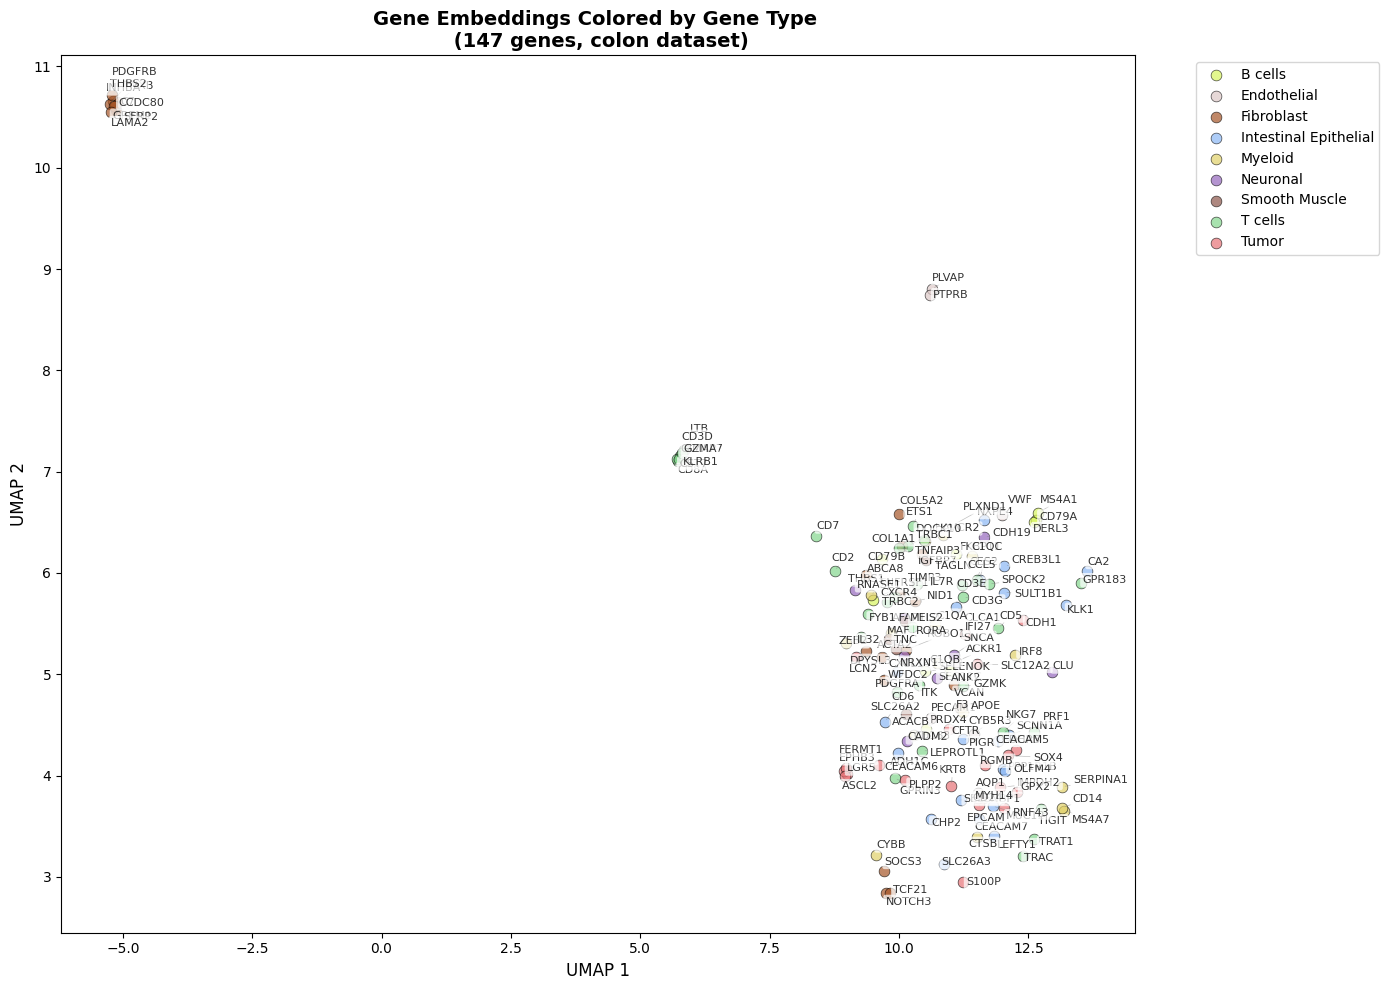

✅ Plot saved to embedding_visualization_results/colon/seq/align_loss/gene_embeddings_by_type.png


In [9]:
if gene_types_dict and 'gene_type' in gene_metadata.columns:
    print("Creating plot colored by gene type...")
    
    # Filter out unknown genes for cleaner visualization
    known_mask = gene_metadata['gene_type'] != 'Unknown'
    plot_metadata = gene_metadata[known_mask].copy()
    plot_embeddings = reduced_embeddings[known_mask]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    cell_type_color_palette = load_cell_type_color_palette()
    
    # Get unique gene types
    gene_types = sorted(plot_metadata['gene_type'].unique())
    colors = []
    for gene_type in gene_types:
        colors.append(cell_type_color_palette[gene_type])
    
    # Add gene name labels with flexible positioning to avoid overlap
    from adjustText import adjust_text
    texts = []
    
    # Plot each gene type
    for gene_type, color in zip(gene_types, colors):
        mask = plot_metadata['gene_type'] == gene_type
        subset_data = plot_metadata[mask]
        subset_embeddings = plot_embeddings[mask]
        
        ax.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1],
                  c=[color], label=gene_type, s=60, alpha=0.7, 
                  edgecolors='black', linewidth=0.5)
        
        # add gene name labels
        for i, (_, gene_row) in enumerate(subset_data.iterrows()):
            text = ax.annotate(gene_row['gene_name'], 
                             (subset_embeddings[i, 0], subset_embeddings[i, 1]),
                             fontsize=8, alpha=0.8,
                             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))
            texts.append(text)
    
    # Adjust text positions to avoid overlap
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5))
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(f'Gene Embeddings Colored by Gene Type \n ({len(plot_metadata)} genes, {DATASET} dataset)', 
                fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(False)
    
    plt.tight_layout()
    plot_path = save_dir / 'gene_embeddings_by_type.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Plot saved to {plot_path}")
else:
    print("Skipping gene type plot - no gene type data available")


## Plot 2: Gene Embeddings Colored by Mutually Exclusive Gene Count


Creating plot colored by mutually exclusive gene count...


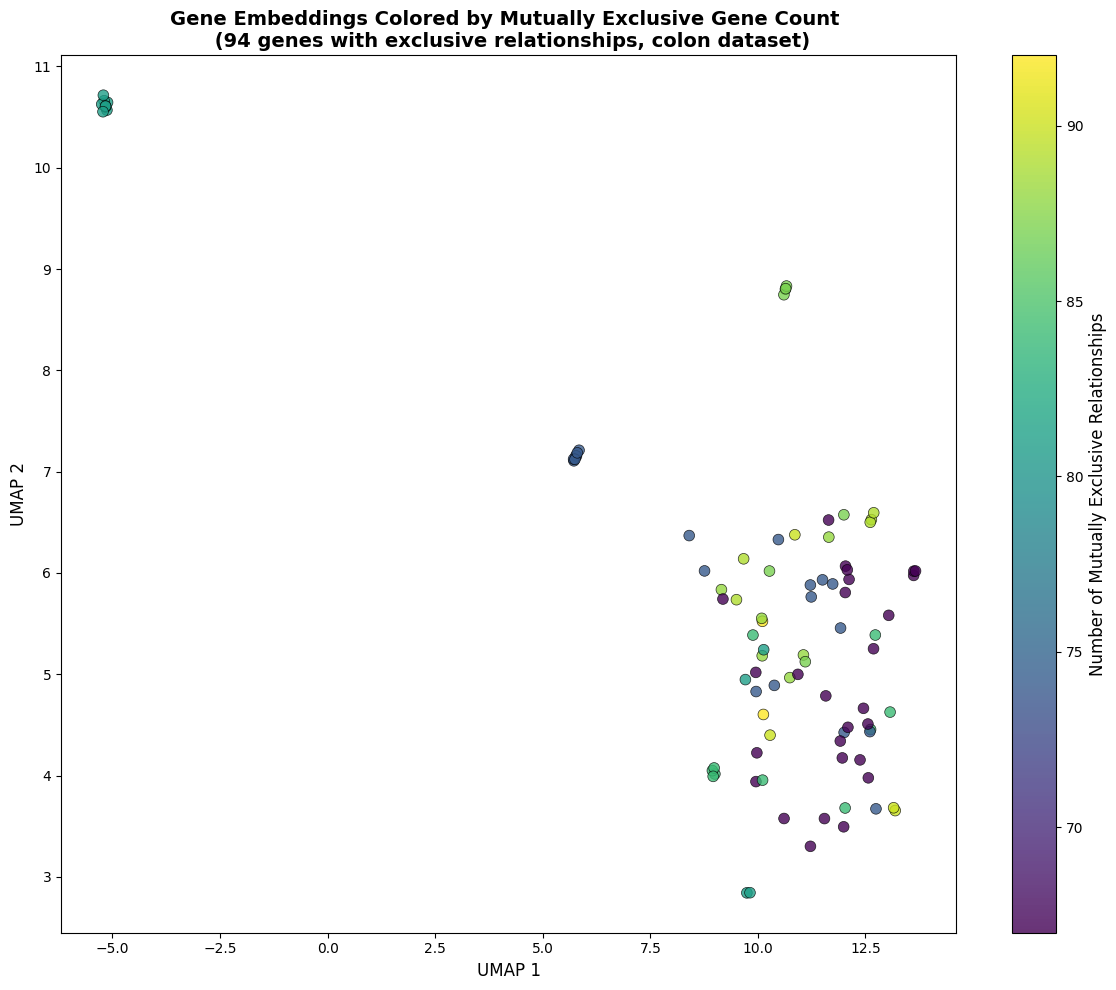

✅ Plot saved to embedding_visualization_results/colon/seq/align_loss/gene_embeddings_by_exclusive_count.png

 Distribution of mutually exclusive counts:
exclusive_count
67    27
74    20
81    13
84    10
87     7
88     6
89     5
90     4
92     2
Name: count, dtype: int64


In [10]:
if gene_exclusive_counts and 'exclusive_count' in gene_metadata.columns:
    print("Creating plot colored by mutually exclusive gene count...")
    
    # Filter genes that have at least one exclusive relationship
    exclusive_mask = gene_metadata['exclusive_count'] > 0
    plot_metadata = gene_metadata[exclusive_mask].copy()
    plot_embeddings = reduced_embeddings[exclusive_mask]
    
    if len(plot_metadata) > 0:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Create scatter plot with color mapping
        scatter = ax.scatter(plot_embeddings[:, 0], plot_embeddings[:, 1],
                           c=plot_metadata['exclusive_count'], 
                           cmap='viridis', s=60, alpha=0.8,
                           edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Number of Mutually Exclusive Relationships', fontsize=12)
        
        ax.set_xlabel('UMAP 1', fontsize=12)
        ax.set_ylabel('UMAP 2', fontsize=12)
        ax.set_title(f'Gene Embeddings Colored by Mutually Exclusive Gene Count \n ({len(plot_metadata)} genes with exclusive relationships, {DATASET} dataset)', 
                    fontsize=14, fontweight='bold')
        ax.grid(False)
        
        plt.tight_layout()
        plot_path = save_dir / 'gene_embeddings_by_exclusive_count.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Plot saved to {plot_path}")
        
        # Show distribution
        print(f"\n Distribution of mutually exclusive counts:")
        print(plot_metadata['exclusive_count'].value_counts().sort_index())
    else:
        print("No genes with mutually exclusive relationships found")
else:
    print("Skipping mutually exclusive gene count plot - no data available")


## Plot 3: Gene Embeddings Colored by Cell Type Candidacy Count


Creating plot colored by cell type candidacy count...


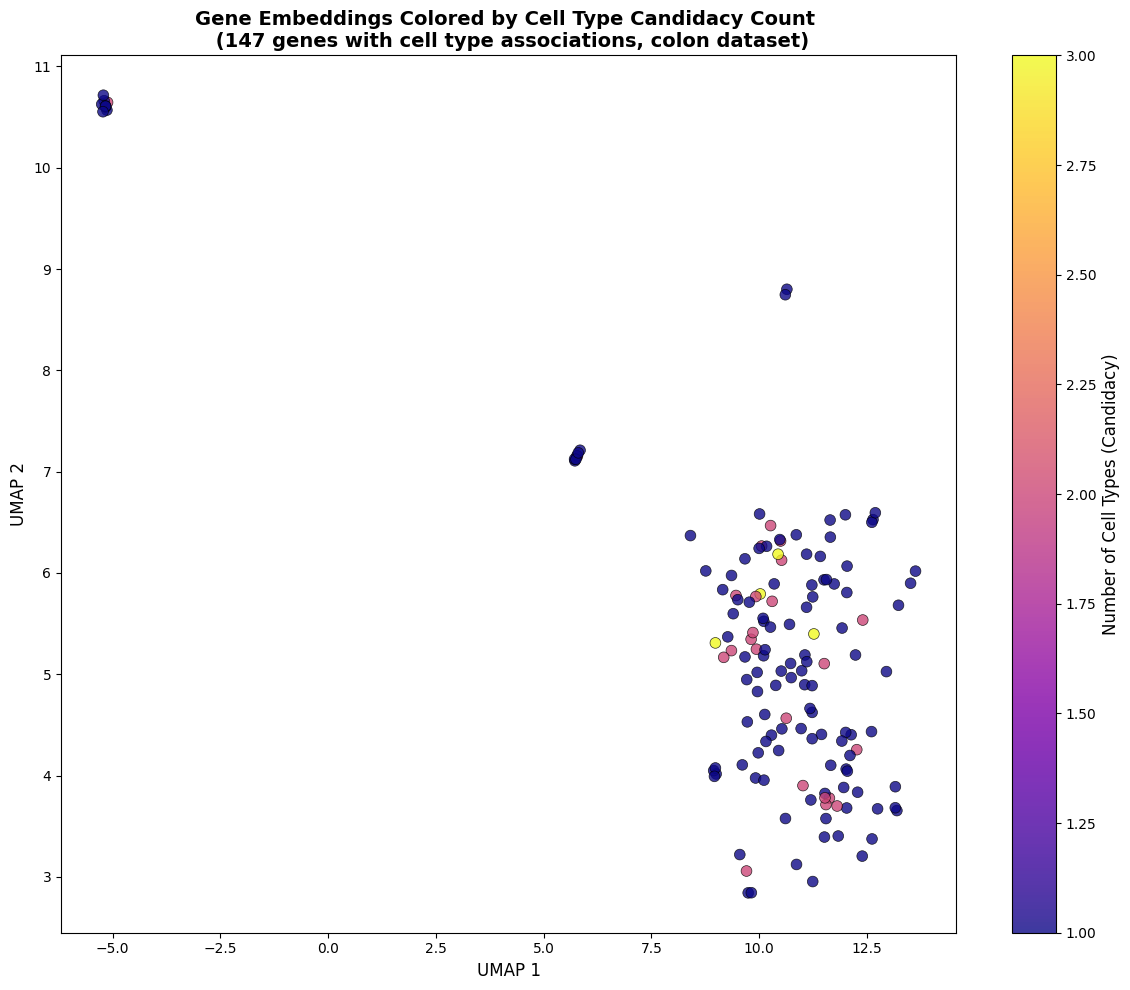

✅ Plot saved to embedding_visualization_results/colon/seq/align_loss/gene_embeddings_by_celltype_candidacy.png
\nDistribution of cell type candidacy counts:
celltype_candidacy_count
1    119
2     24
3      4
Name: count, dtype: int64


In [11]:
if gene_celltype_counts and 'celltype_candidacy_count' in gene_metadata.columns:
    print("Creating plot colored by cell type candidacy count...")
    
    # Filter genes that were candidates for at least one cell type
    candidate_mask = gene_metadata['celltype_candidacy_count'] > 0
    plot_metadata = gene_metadata[candidate_mask].copy()
    plot_embeddings = reduced_embeddings[candidate_mask]
    
    if len(plot_metadata) > 0:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Create scatter plot with color mapping
        scatter = ax.scatter(plot_embeddings[:, 0], plot_embeddings[:, 1],
                           c=plot_metadata['celltype_candidacy_count'], 
                           cmap='plasma', s=60, alpha=0.8,
                           edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Number of Cell Types (Candidacy)', fontsize=12)
        
        ax.set_xlabel('UMAP 1', fontsize=12)
        ax.set_ylabel('UMAP 2', fontsize=12)
        ax.set_title(f'Gene Embeddings Colored by Cell Type Candidacy Count \n ({len(plot_metadata)} genes with cell type associations, {DATASET} dataset)', 
                    fontsize=14, fontweight='bold')
        ax.grid(False)
        
        plt.tight_layout()
        plot_path = save_dir / 'gene_embeddings_by_celltype_candidacy.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Plot saved to {plot_path}")
        
        # Show distribution
        print(f"\\nDistribution of cell type candidacy counts:")
        print(plot_metadata['celltype_candidacy_count'].value_counts().sort_index())
    else:
        print("No genes with cell type candidacy found")
else:
    print("Skipping cell type candidacy count plot - no data available")


## Combined Analysis: Correlation Between Metrics


Creating correlation analysis...


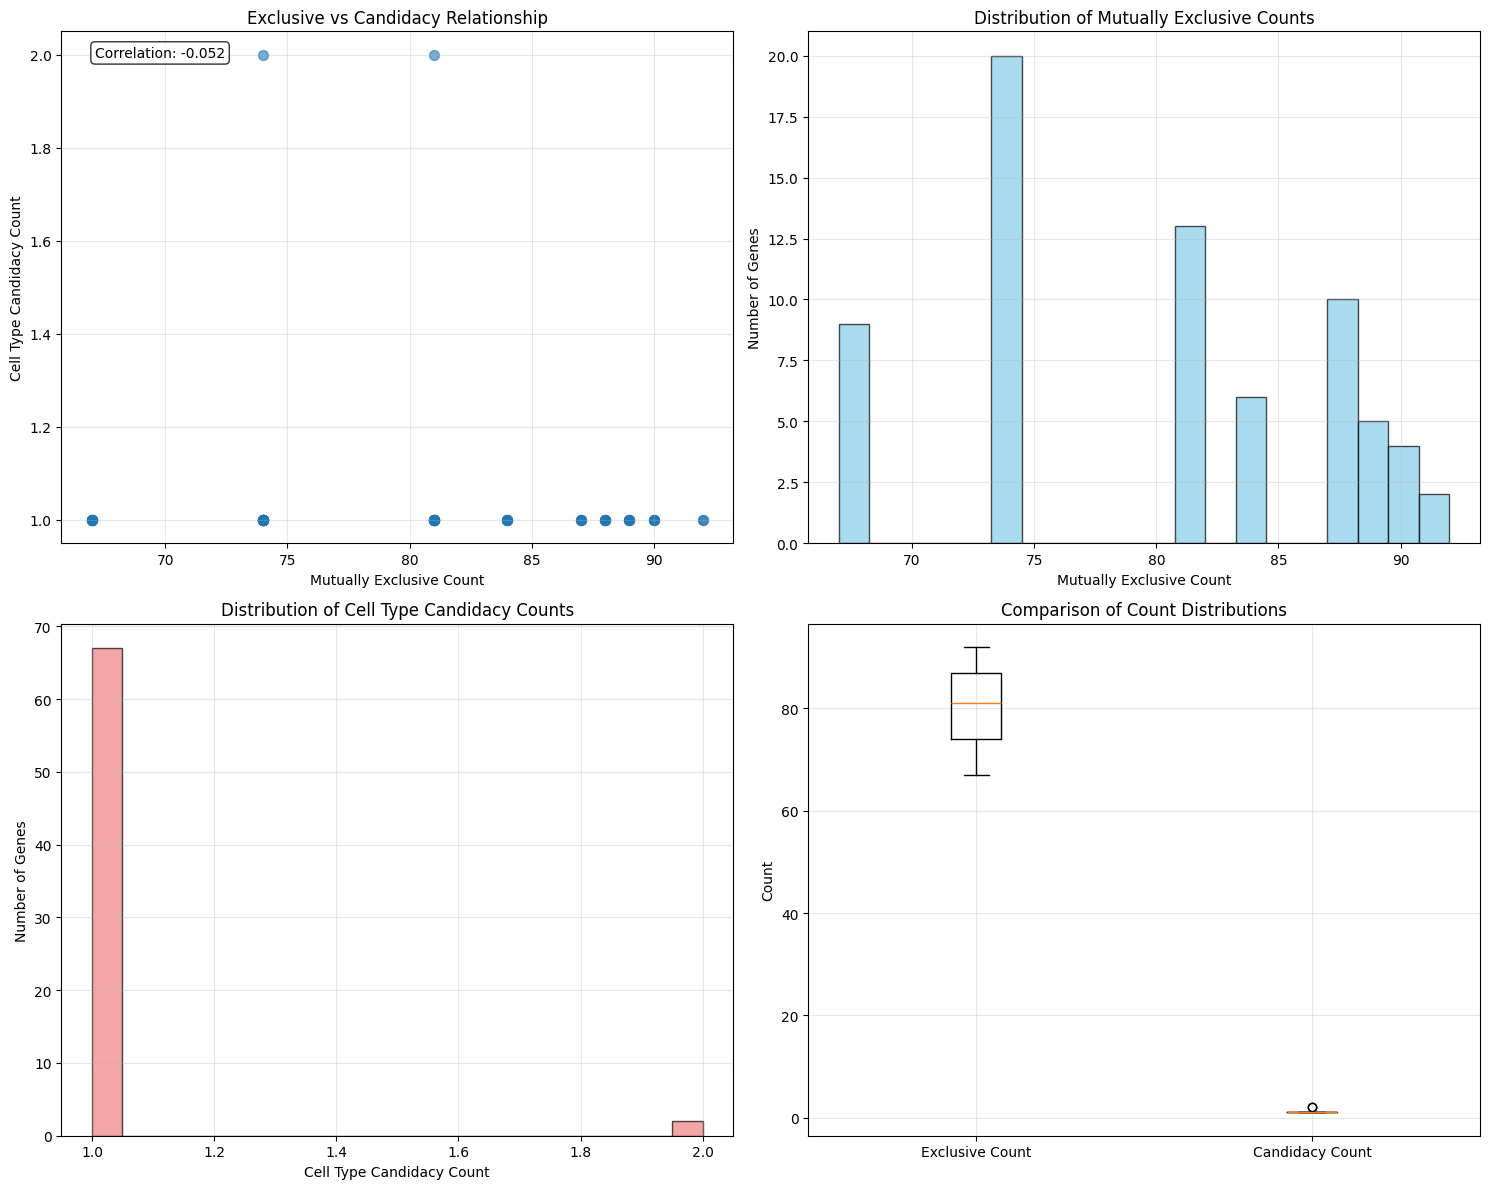

✅ Correlation analysis saved to embedding_visualization_results/colon/seq/align_loss/gene_metrics_correlation_analysis.png
\nCorrelation between exclusive count and candidacy count: -0.052
Number of genes with both metrics: 69


In [12]:
if (gene_exclusive_counts and gene_celltype_counts and 
    'exclusive_count' in gene_metadata.columns and 
    'celltype_candidacy_count' in gene_metadata.columns):
    
    print("Creating correlation analysis...")
    
    # Filter genes that have both metrics > 0
    both_mask = (gene_metadata['exclusive_count'] > 0) & (gene_metadata['celltype_candidacy_count'] > 0)
    analysis_data = gene_metadata[both_mask].copy()
    
    if len(analysis_data) > 10:  # Need sufficient data points
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Scatter plot: Exclusive count vs Candidacy count
        ax1.scatter(analysis_data['exclusive_count'], analysis_data['celltype_candidacy_count'], 
                   alpha=0.6, s=50)
        ax1.set_xlabel('Mutually Exclusive Count')
        ax1.set_ylabel('Cell Type Candidacy Count')
        ax1.set_title('Exclusive vs Candidacy Relationship')
        ax1.grid(True, alpha=0.3)
        
        # Compute correlation
        correlation = analysis_data['exclusive_count'].corr(analysis_data['celltype_candidacy_count'])
        ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Distribution of exclusive count
        ax2.hist(analysis_data['exclusive_count'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_xlabel('Mutually Exclusive Count')
        ax2.set_ylabel('Number of Genes')
        ax2.set_title('Distribution of Mutually Exclusive Counts')
        ax2.grid(True, alpha=0.3)
        
        # Distribution of candidacy count
        ax3.hist(analysis_data['celltype_candidacy_count'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        ax3.set_xlabel('Cell Type Candidacy Count')
        ax3.set_ylabel('Number of Genes')
        ax3.set_title('Distribution of Cell Type Candidacy Counts')
        ax3.grid(True, alpha=0.3)
        
        # Box plot comparison
        box_data = [analysis_data['exclusive_count'], analysis_data['celltype_candidacy_count']]
        ax4.boxplot(box_data, labels=['Exclusive Count', 'Candidacy Count'])
        ax4.set_ylabel('Count')
        ax4.set_title('Comparison of Count Distributions')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path = save_dir / 'gene_metrics_correlation_analysis.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Correlation analysis saved to {plot_path}")
        print(f"\\nCorrelation between exclusive count and candidacy count: {correlation:.3f}")
        print(f"Number of genes with both metrics: {len(analysis_data)}")
    else:
        print(f"Insufficient data for correlation analysis ({len(analysis_data)} genes)")
else:
    print("Skipping correlation analysis - missing data")
